## Restore function coefficients
Given: values of a function: `f(x) = (a+ad)e^x + (b+bd)x^3/4 + (c+cd)*(cos(x))^2`  
       where ad, bd - random values in [-0.1,0.1]  
Objective: restore a, b, c coefficients

In [1]:
import pandas as pd
import numpy as np
import math
import random
from tqdm import notebook, tqdm
import matplotlib.pyplot as plt

import torch

In [2]:
os.chdir('E:\\Coding\\Jupyter Workspace\\Experiments\\Udod_Identification')
data = pd.read_csv('coeff_data.txt', header=None, sep=' ')
data.columns = ['x', 'fx']
print(data.info())
data

FileNotFoundError: [Errno 2] No such file or directory: 'coeff_data.txt'

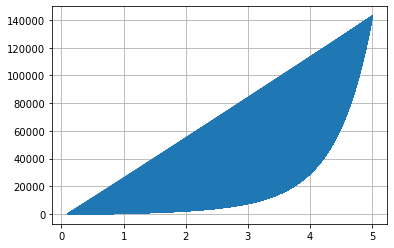

In [36]:
plt.plot(x,y)
plt.grid()
plt.show()

### Model
No analitical decision, have to use numerical methods. Pytorch gradient is most convenient way

In [116]:
def plot_history(history):
    
    def plot1(ax, col, log_scale=False):
        ax.plot(history[col])
        ax.set_title(col)
        ax.grid()
        if log_scale:
            ax.set_yscale('log')
    
    N = len(history.columns) - 1
    fig, ax1 = plt.subplots(1, N, figsize=(16,4))
    for i in range(N):
        plot1(ax1[i], history.columns[i+1])
    
    fig, ax2 = plt.subplots(figsize=(16,4))
    plot1(ax2, history.columns[0], log_scale=True)
    plt.show()

In [369]:
def myfunc(x, a, b, c):
    return (a * torch.exp(x) + b * x ** 0.75) ** 2 + c * torch.cos(x) ** 2

In [414]:
def find_coeffs(x, y, myfunc, lr=1e-5, N=100, coef=[], early_stop=0.1):

    dtype = torch.float
    device = torch.device("cpu")
    #device = torch.device("cuda:0")  # Uncomment this to run on GPU

    if isinstance(lr, float):
        lr = [lr]
    while len(lr) < len(coef):
        lr.append(lr[-1])
    
    cf = []
    for j in coef:
        cf.append(torch.tensor([j], dtype=dtype, requires_grad=True))

    # a couple of buffers to hold parameter and loss history
    loss_history = []
    cf_history = []

    for i in range(N):
        # Forward pass: compute predicted y using operations on Tensors.
        y_pred = myfunc(x, cf[0], cf[1], cf[2])

        # Compute and print loss using operations on Tensors.
        # Now loss is a Tensor of shape (1,)
        # loss.item() gets the scalar value held in the loss.
        loss = (y_pred - y).pow(2).sum()
        if i % (N/10) == (N/10-1):
            str_cf = ''
            for j in cf:
                str_cf += '  ' + str(np.round(j.item(),3))
            print(i, np.round(loss.item(),3), str_cf)

        if loss<early_stop:
            print('Early stop')
            break

        # Do some recordings for plots
        loss_history.append(loss.data)
        cf_tmp = []
        for j in cf:
            cf_tmp.append(j.item())
        cf_history.append(cf_tmp)

        # Use autograd to compute the backward pass. This call will compute the
        # gradient of loss with respect to all Tensors with requires_grad=True.
        # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
        # the gradient of the loss with respect to a, b, c, d respectively.
        loss.backward()

        # Manually update weights using gradient descent. Wrap in torch.no_grad()
        # because weights have requires_grad=True, but we don't need to track this
        # in autograd.
        with torch.no_grad():
            for j in range(len(cf)):
                cf[j] -= lr[j] * cf[j].grad
                cf[j].grad = None
        
    print('\nCoefficients:')
    for j in cf:
        print(np.round(j.item(),5))
    
    history = pd.DataFrame(data={'loss': loss_history})
    cf_history = np.array(cf_history).T
    for j in range(len(cf_history)):
        history['c'+str(j)] = cf_history[j]
                                               
    plot_history(history)
    return cf

#### Real data

In [ ]:
x = torch.tensor(data['x'])
y = torch.tensor(data['fx'])

99 147029245255.964   2.235  15.299  19.653
199 15052298955.671   2.137  18.628  25.319
299 1428482264.096   2.105  19.69  27.019
399 165034651.263   2.095  20.013  27.456
499 51677356.389   2.093  20.11  27.511
599 41511407.561   2.092  20.139  27.451
699 40506371.179   2.091  20.148  27.358
799 40312021.399   2.091  20.151  27.255
899 40190214.813   2.091  20.151  27.149
999 40075544.73   2.091  20.152  27.043

Coefficients:
2.09132
20.15188
27.04149


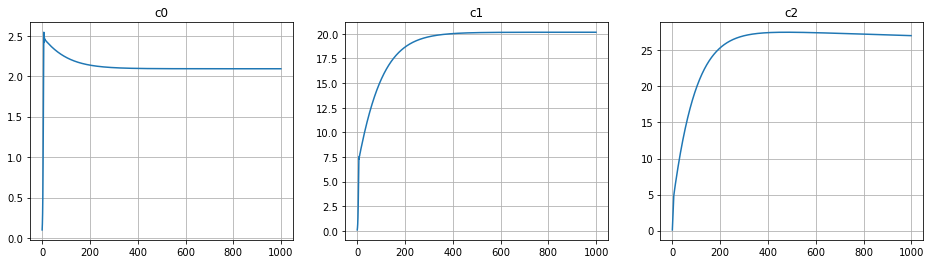

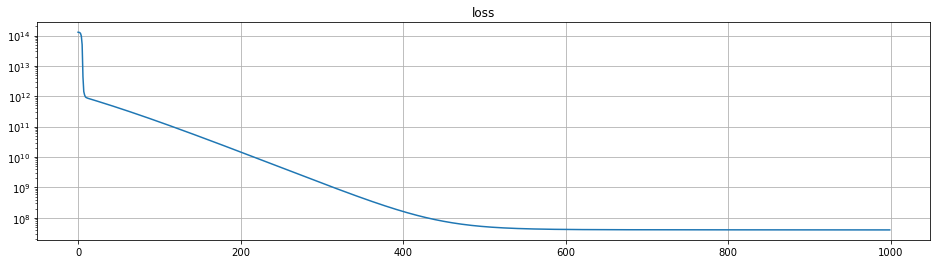

In [424]:
res = find_coeffs(x, y, myfunc, lr=[1e-14,1e-12,1e-9], N=1000, coef=[0.1,0.1,0.1], early_stop=0.01)

9999 23617334.905   2.09  20.199  -3.043
19999 23607337.01   2.09  20.2  -3.737
29999 23607300.284   2.09  20.2  -3.757
39999 23607300.284   2.09  20.2  -3.757
49999 23607300.284   2.09  20.2  -3.757
59999 23607300.284   2.09  20.2  -3.757
69999 23607300.284   2.09  20.2  -3.757
79999 23607300.284   2.09  20.2  -3.757
89999 23607300.284   2.09  20.2  -3.757
99999 23607300.284   2.09  20.2  -3.757

Coefficients:
2.09
20.19997
-3.75745


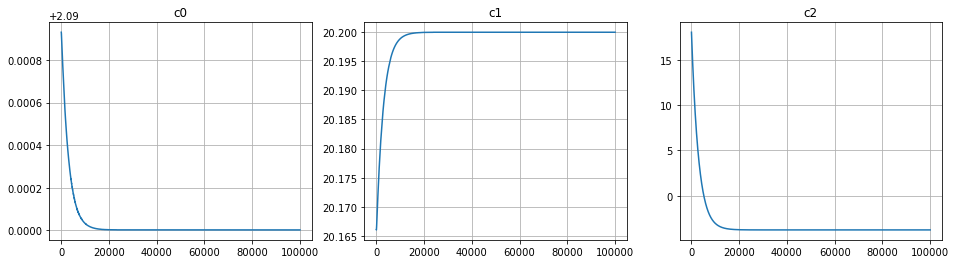

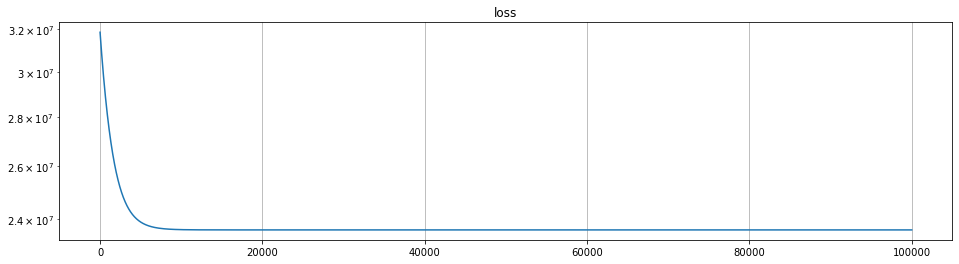

In [426]:
res = find_coeffs(x, y, myfunc, lr=[1e-14,1e-12,1e-8], N=100000, coef=[2.09093,20.16603,18.03464], early_stop=0.01)

#### This is right answer